<a href="https://colab.research.google.com/github/cjcalderon9804/airbnb-sentiment-analysis/blob/main/airbnb_sentiment_analysis_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis for Airbnb reviews

 This project addresses one of the most interesting applications when working with **Natural Language Processing (NLP)** with Python, which consists of **Sentiment Analysis** applied to a real sample data set corresponding to 620 reviews given by guests to a total of 10 accommodations listed within the temporary accommodation platform *Airbnb* for the iconic Ecuadorian tourist city with unique beaches and very welcoming people that is **Montañita**. This project complies with the code style and format guidelines dictated in the ***PEP-8*** manual, in addition to ***HTML Entities*** to help the correct readability of special characters, such as *tildes * and *ñ*.

 # Initial preprocessing of information

 ## Installation and import of necessary libraries

Because several of the reviews contain *emojis*, it will be necessary to have a library for their respective treatment and transformation, to later use them when performing the sentiment analysis. The library that is installed is called ***emoji***.

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 6.8 MB/s eta 0:00:00


Libraries such as ***pandas***, ***numpy***, ***os***, ***glob*** and ***pathlib*** are also imported, which will be used for different purposes, from manipulating files and folders within the virtual machine to creating ***DataFrames*** and using mathematical functions.

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path

 Pandas is configured to prevent it from truncating the text of the entries in each of the columns. Additionally, the base directory is changed with the ***os*** library for greater ease of work. The base directory contains the reviews left by guests of a total of 10 different accommodations located on Montañita beach, Ecuador, as of Friday, January 6, 2024.

In [ ]:
default_max_colwidth = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', None)

The code block contained in the following cell should be executed only if the ***notebook*** files are stored in ***Google Drive*** and if it is also executed within the platform ***Google Colab***, for which it is necessary to replace *root_path* with the path corresponding to the root directory where the files will be stored. This is so that in subsequent cells it is not necessary to type the full path each time. Conversely, if you run ***notebook*** in a local environment, you can skip the cell entirely.

In [ ]:
root_path = "/content/drive/MyDrive/PORTFOLIO/Sent_Analysis"
reviews_path = os.path.join(root_path, "abb_reviews")
os.chdir(root_path)
# Verificación de cambio de directorio
print(f"Directorio actual: {os.getcwd()}")

Directorio actual: /content/drive/MyDrive/PORTFOLIO/Sent_Analysis


 A list is obtained with all the files corresponding to the reviews of 10 accommodations in total.

In [ ]:
# Se define un patrón para buscar archivos txt en el directorio
patron = '*.txt'

# Se usa glob para obtener la lista de archivos que coinciden con el patrón
abb_reviews = glob.glob(os.path.join(reviews_path, patron))

# Se ordenan las reseñas en orden alfabético
abb_reviews = sorted(
    abb_reviews,
    key=lambda x: int(Path(x).stem.split('_')[-1]))

 ## Review count for each file

In [ ]:
total_resenas = 0
for archivo in abb_reviews:
    archivo_path = Path(archivo)
    with open(archivo_path, mode="r", encoding="utf-8") as file:
        foo = file.read()
        print(f'Número de reseñas en {archivo_path.name}:\
         {foo.count("Calificación: ")}')
        total_resenas += foo.count("Calificación: ")

print(f"\nTotal de reseñas en {len(abb_reviews)} archivos: {total_resenas}")

Número de reseñas en abb_reviews_00.txt:         9
Número de reseñas en abb_reviews_01.txt:         17
Número de reseñas en abb_reviews_02.txt:         141
Número de reseñas en abb_reviews_03.txt:         15
Número de reseñas en abb_reviews_04.txt:         38
Número de reseñas en abb_reviews_05.txt:         8
Número de reseñas en abb_reviews_06.txt:         200
Número de reseñas en abb_reviews_07.txt:         29
Número de reseñas en abb_reviews_08.txt:         22
Número de reseñas en abb_reviews_09.txt:         141

Total de reseñas en 10 archivos: 620


 ## Feature to extract guest reviews from all files

It can be seen that some of the information collected is not previously structured, that is, there are comments with different attributes than others, such as, for example, "*Stayed for a few weeks*" or "*With pet*". This is why these expressions are eliminated to prevent them from being mistakenly interpreted as comments.

In [ ]:
def extraer_comentarios(mi_archivo):
    comentarios = []
    with open(mi_archivo, mode="r", encoding="utf-8") as file:
        texto = file.read()

    # Dividir el texto en fragmentos usando "Calificación:" como delimitador
    fragmentos = texto.split("Calificación:")[1:]

    # Eliminación de fragmentos vacíos
    fragmentos = [
        fragmento.strip() for fragmento in fragmentos if fragmento.strip()
    ]
    for fragmento in fragmentos:
        aux = (
            fragmento.replace(",·", "")
            .replace("Se quedó unas semanas", "")
            .replace("Estadía de una semana", "")
            .replace("Con mascota", "")
        )
        aux = "\n".join(
            linea.strip() for linea in aux.splitlines() if linea.strip()
        )
        comentarios.append(aux.splitlines()[2])

    return comentarios

 A list is created to store all the reviews (which in turn are in lists) which will be stored in a ***Pandas DataFrame*** along with the ratings.

In [ ]:
lista_reviews = []

In [ ]:
for review_file in abb_reviews:
    lista_reviews.append(extraer_comentarios(review_file))

 It is verified with the ***len*** function that there are actually ***620*** reviews in total, which is true, and subsequently a plain text file is created to verify the comments.

In [ ]:
print(len(sum(lista_reviews, [])))

620


 All reviews are saved in a text file to manually verify using an external text editor that each of the 620 lines corresponding to comments are indeed comments and not other attributes of the reviews.

In [ ]:
if not os.path.exists("processing/coment_ALL.txt"):
    with open("processing/coment_ALL.txt", mode="w") as file:
        file.write("\n".join(sum(lista_reviews, [])))

## Feature to extract guest ratings from all files

 Additionally, for sentiment analysis it is important to extract the rating from 1 to 5 that users gave in each of the reviews to contrast them with the result of the sentiment analysis. As with the comments themselves, the scores are also stored in list format and then create a ***Pandas DataFrame*** with them.

In [ ]:
def extraer_calificaciones(mi_archivo):
    stars = []
    with open(mi_archivo, mode="r", encoding="utf-8") as file:
        texto = file.read()
        fragmentos = texto.split("Calificación: ")

    for i in range(1, len(fragmentos)):
        stars.append(int(fragmentos[i][0]))

    return stars

In [ ]:
lista_stars = []

for review_file in abb_reviews:
    lista_stars.append(extraer_calificaciones(review_file))

 It is verified that the number of ratings is the same as the number of comments.

In [ ]:
len(sum(lista_stars, []))

620

 Indexes are created to identify each of the 10 accommodations prior to the creation of the *Pandas* *DataFrame*. Likewise, all the elements of reviews and number of stars for each accommodation are combined into a single list for each case.

In [ ]:
def unir_listas(lista):
    return sum(lista, [])

In [ ]:
numero_resenas = []

In [ ]:
for resena in lista_reviews:
    numero_resenas.append(len(resena))

In [ ]:
numero_resenas

[9, 17, 141, 15, 38, 8, 200, 29, 22, 141]

In [ ]:
id_alojamiento = []
for index, i in enumerate(numero_resenas, start=0):
    id_alojamiento.append(list(np.full(i, index)))

id_alojamiento = sum(id_alojamiento, [])

In [ ]:
lista_reviews = unir_listas(lista_reviews)
lista_stars = unir_listas(lista_stars)

 ## Pandas DataFrame Construction

In [ ]:
df_reviews = pd.DataFrame({
    "id_alojamiento": id_alojamiento,
    "review": lista_reviews,
    "stars": lista_stars,
})

 A sampling is carried out in order to verify that the *DataFrame* was constructed correctly and it is saved in *csv* format for future use.

In [ ]:
df_reviews.sample(5)

,id_alojamiento,review,stars
369,6,This is a good value in Montanita. It is a good location away from the central chaos but a close walk. It has AC and a nice view.,5
50,2,Excelente y jonny es muy chevere. Tiene buena energia,5
206,4,"Aparte de ser un lugar increíble, acogedor, perfectamente ubicado para poder disfrutar de una vista maravillosa del mar, también cuenta con una host fenomenal como Tania, quien fue muy atenta con nosotros. Muy gustosa nos hizo un mini tour de lugares deliciosos para comer, o disfrutar de cócteles frente al atardecer. Hospedarse aquí es una experiencia que de seguro querrás volver a vivir. Recomendadísimo!!",5
270,6,"La verdad no le doy las 5 estrellas porque la cama estaba con algo de polvo y sería recomendable cambiar o lavar y aspirar porque mi novia y yo tuvimos alergias. El otro detalle es que el camino de ma entrada estuvo algo peligroso en caso de lluvia y mucha maleza a los lados que provocan mosquitos, de ahí todo perfecto me gusto porque es acogedor, pude hubo una vista muy linda",3
451,7,"Such a cool spot. I am a woman traveling alone through Ecuador from the US and this was one of my favorite spots. The place is so stylish and unique, it represented the best parts of travel. While not luxurious in a traditional sense (composting toilet and cold shower) it offers a sort of opulence that is much harder to find. My room was huge and had a private balcony looking over the town of Montanita and the coast. Hammocks in the the room and on the balcony and lots of little handmade tables for a drink and a book (superfluous furniture is definitely a luxury in Ecuador). Beautiful wood floors and abundant windows. The wi-fi was great and the noise from Montanita very minimal. I highly recommend having an adventure at this glorious and unforgettable hostel!",5


In [ ]:
if not os.path.exists("processing/df_reviews.csv"):
    df_reviews.to_csv("processing/df_reviews.csv", index=False)

The reviews left by guests are then translated to the accommodations with the help of **Google Cloud Translate**, which automatically detects the language of the input texts and translates them into English in order to process them. later when performing the sentiment analysis. For subsequent runs of this *Jupyter Notebook*, the file with the already translated reviews is imported in order not to exceed the quota of translations allowed in the free tier of *Google Cloud Translate*. If you want to replicate the use of ***Google Cloud Translate*** for automatic text translation, you must use an existing ***Google Cloud*** account or create a new account and generate the credentials. access to the API, following the documentation of the cloud service provider. The reason why data is stored in *.xlsx* format instead of *.csv* is that sometimes the ***Pandas*** interpreter confuses certain special characters with data delimiters and a error occurs. wrong reading for some of the records.

In [ ]:
df_traducciones = pd.DataFrame()

In [ ]:
from google.cloud import translate_v2 as translate

# Lectura de llave privada de la API de Google Cloud Translate
client = translate.Client.from_service_account_json(
    "processing/private_key_translate.json"
)

if not os.path.exists("translations/df_reviews_traducido.xlsx"):
    # Función para traducir un texto
    def translate_text(text, target_language='en'):
        result = client.translate(text, target_language=target_language)
        return result['translatedText']

    # Traducción de texto en la columna "review"
    df_reviews['texto_traducido'] = df_reviews["review"].apply(
        lambda x: translate_text(x, target_language="en")
    )

    # Almacenamiento de reseñas traducidas para uso futuro
    df_reviews[[
            "id_alojamiento", "review", "texto_traducido", "stars"
        ]].to_excel(
        "translations/df_reviews_traducido.xlsx", index=False
    )

else:
    df_reviews['texto_traducido'] = pd.read_excel(
        "translations/df_reviews_traducido.xlsx"
    )["texto_traducido"]

 random sample of the data is obtained in order to verify the translations made.

In [ ]:
df_reviews.sample(10)

,id_alojamiento,review,stars,texto_traducido
11,1,I don't think this should be listed on Airbnb as an entire apartment. It's a very small motel room (one of many) with a sink in the corner and an open space outside. There is a shared outdoor kitchen.,3,I don't think this should be listed on Airbnb as an entire apartment. It's a very small motel room (one of many) with a sink in the corner and an open space outside. There is a shared outdoor kitchen.
494,9,Great place! Everything was as advertised. Response from the host is fast and accurate. Would visit here again!,5,Great place! Everything was as advertised. Response from the host is fast and accurate. Would visit here again!
612,9,"My husband and I enjoyed our days on Gijs & Liliana apartment. It's a beautiful and quiet place on Manglaralto, where you can rest. It's 15 minutes near Montañita and only 5 minutes near the beach.",5,"My husband and I enjoyed our days on Gijs & Liliana apartment. It's a beautiful and quiet place on Manglaralto, where you can rest. It's 15 minutes near Montañita and only 5 minutes near the beach."
536,9,We had as good a stay as possible at the lovely apartment of Gijs and Liliana's place in Manglaralto. A cute place with everything we needed. A very comfortable bed and pillows.,5,We had as good a stay as possible at the lovely apartment of Gijs and Liliana's place in Manglaralto. A cute place with everything we needed. A very comfortable bed and pillows.
128,2,"Muy bueno apartamento : ubicaccion, vista sobre la playa, aire accondicionado, buena cama, todo bien.",5,"Very good apartment: location, view of the beach, air conditioning, good bed, everything good."
399,6,Práctico para quedarse un par de noches. Buena respuesta del anfitrión.,4,Practical to stay a couple of nights. Good response from the host.
220,5,El anfitrión fue muy amable desde el principio hasta el final. El alojamiento se encuentra muy cerca a la playa y a la zona de restaurantes y bares por lo cual es una buena opción.,5,"The host was very friendly from start to finish. The accommodation is very close to the beach and the area of restaurants and bars, making it a good option."
13,1,"Great place! Close to the beach, nice outside kitchen, quiet at night, budget friendly. Enjoy!",5,"Great place! Close to the beach, nice outside kitchen, quiet at night, budget friendly. Enjoy!"
351,6,"This is the second time I have stayed here and it was as enjoyable as the first. This is a very cozy nice,place to stay. I highly recommend it.",5,"This is the second time I have stayed here and it was as enjoyable as the first. This is a very cozy nice,place to stay. I highly recommend it."
517,9,Lugar muy acogedor y todo ordenado. Siempre estuvieron pendientes de uno,5,Very cozy place and everything tidy. They were always looking out for you


 # Preparation of data for Sentiment Analysis

 ##: Removal of punctuation marks, articles and unnecessary words:

 The **nltk** library is imported to detect and eliminate from the comments left by guests and previously translated into English, the articles, words and punctuation marks that will not be useful when performing the sentiment analysis, and is stored in a new column of the *DataFrame* called "*text_without_stopwords*".

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')


def remover_articulos(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_traducido"].apply(
    lambda x: remover_articulos(x)
)

 Regular expressions are also used to treat excess spaces as well as punctuation marks and unnecessary characters for sentiment analysis. In addition, the data is prepared for the processing of emojis.

In [ ]:
import re


def extraer_no_letras(texto):
    return list(set(re.sub('[a-zA-Z0-9]', '', texto)))

In [ ]:
df_reviews["no_texto"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: extraer_no_letras(x)
)

In [ ]:
non_text_chars = list(set(df_reviews["no_texto"].sum()))
non_text_chars.remove(" ")
df_reviews.drop(["no_texto"], axis=1, inplace=True)

 ## Emoji treatment

 list of all the emojis present in the reviews given by guests is extracted from the previously defined variable "*non_text_chars*". Additionally, an English word is assigned to give an appropriate interpretation to each of these. Finally, emojis are replaced with their word equivalents.

In [ ]:
import emoji

emojis_list = [i for i in non_text_chars if emoji.is_emoji(i)]
emojis_dict = {
    '✨': 'sparkling',
    '🙃': 'sarcastic',
    '💖': 'beautiful',
    '😔': 'sad',
    '🙌': 'celebration',
    '😘': 'affectionate',
    '⭐': 'star',
    '👏': 'applause',
    '💕': 'affectionate',
    '😊': 'happy',
    '😍': 'admiration',
    '💓': 'emotion',
    '❣': 'emotion',
    '💜': 'affection',
    '🙈': 'playful',
    '🤗': 'friendly',
    '👌': 'approval',
    '🏻': '',
    '🍻': 'celebration',
    '🌞': 'cheerful',
    '❤': 'love',
    '♥': 'love',
    '💯': 'perfect',
    '👍': 'approval'
}

In [ ]:
non_emoji_chars = [i for i in non_text_chars if not emoji.is_emoji(i)]

In [ ]:
def quitar_simbolos(texto):
    for char in non_emoji_chars:
        texto = texto.replace(char, "")
    return texto

In [ ]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: quitar_simbolos(x)
)

In [ ]:
df_reviews["texto_sin_stopwords"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: " ".join(x.split())
)

 A function is defined to replace emojis with their word equivalents.

In [ ]:
def reemplazar_emojis(texto):
    for (key, value) in emojis_dict.items():
        texto = texto.replace(key, f" {value} ")
    return texto

In [ ]:
df_reviews["texto_sin_emojis"] = df_reviews["texto_sin_stopwords"].apply(
    lambda x: reemplazar_emojis(x)
)
df_reviews["texto_sin_emojis"] = df_reviews["texto_sin_emojis"].apply(
    lambda x: " ".join(x.split())
)

 Two comments containing emojis are verified to show that the removal of *stopwords* and the replacement of emojis with ***equivalent words*** was done correctly, and finally this version of the *DataFrame* clean of emojis is saved in a file of Microsoft Excel.

In [ ]:
df_reviews[["texto_traducido", "texto_sin_stopwords", "texto_sin_emojis"]] \
    .iloc[[76, 263], :]

,texto_traducido,texto_sin_stopwords,texto_sin_emojis
76,"Everything is very nice, safe and cozy😊",Everything nice safe cozy😊,Everything nice safe cozy happy
263,A quiet place with a good location. They are pet friendly 😊,quiet place good location pet friendly 😊,quiet place good location pet friendly happy


In [ ]:
if not os.path.exists("processing/df_limpio_emojis.xlsx"):
    df_reviews.to_excel("processing/df_limpio_emojis.xlsx")

 # Sentiment Analysis

Finally, a ***sentiment analysis*** is carried out on all the comments present, for which the ***nltk*** library is imported and the ***vader_lexicon*** component is used for the polarity analysis in each of the comments. First, a function is defined that classifies the comments based on their polarity into the categories of **Positive**, **Negative** or **Neutral**, and the results are sent using a *lambda* function. to a new column of the Pandas ***DataFrame***.

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def clasificar_comentario(comentario):
    polaridad = sia.polarity_scores(comentario)['compound']
    if polaridad > 0.05:
        return "Positivo"
    elif polaridad < -0.05:
        return "Negativo"
    else:
        return "Neutral"

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df_reviews["Sentimiento"] = df_reviews["texto_sin_emojis"].apply(
    lambda x: clasificar_comentario(x)
)

 Sample of the columns corresponding to the ***comments translated into English*** and the ***feelings detected***.

In [ ]:
df_reviews[["texto_sin_emojis", "Sentimiento"]].sample(3)

,texto_sin_emojis,Sentimiento
588,Lovely place quiet location town minutes walk popular town hosts caring flat advertised good kitchen utensils,Positivo
410,mini apartment described Cute little place everything need plus incredible view looking town ocean Really enjoyed time,Positivo
335,nice place away noise nice view comfortable good facilities within,Positivo


 Additionally, the reviews are optionally translated into Spanish in order to perform a manual classification of the feelings that would be expected in each case.

In [ ]:
from google.cloud import translate_v2 as translate

# Lectura de llave privada de la API de Google Cloud Translate
client = translate.Client.from_service_account_json(
    "processing/private_key_translate.json"
)

if not os.path.exists("translations/df_reviews_traducido_es.xlsx"):
    # Función para traducir un texto
    def translate_text(text, target_language='es'):
        result = client.translate(text, target_language=target_language)
        return result['translatedText']

    # Traducción de texto en la columna "review"
    df_reviews['texto_traducido_es'] = df_reviews["review"].apply(
        lambda x: translate_text(x, target_language="es")
    )

    # Almacenamiento de reseñas traducidas para uso futuro
    df_reviews[[
            "id_alojamiento", "review", "texto_traducido", "stars"
        ]].to_excel(
        "translations/df_reviews_traducido_es.xlsx", index=False
    )

else:
    df_reviews['texto_traducido_es'] = pd.read_excel(
        "translations/df_reviews_traducido_es.xlsx"
    )["texto_traducido"]

In [ ]:
if not os.path.exists("output/sentimientos.xlsx"):
    df_reviews.to_excel("output/sentimientos.xlsx", index= False)

 Restored the maximum width of columns displayed in the ***PandasDataFrame*** for better visualization.

In [ ]:
pd.set_option('display.max_colwidth', default_max_colwidth)

The *'real'* polarity of the reviews is manually evaluated in order to create a confusion matrix and perform an analysis of the accuracy of this model. However, it is important to keep in mind that this analysis of the *'real'* polarity or validation data set is subject to the criteria of the person who performs it, which is why it cannot be considered at any time as a model. free of bias and interpretation.

In [ ]:
df_sentiments = pd.read_excel("output/matriz_sentimientos.xlsx")
df_sentiments = df_sentiments[["Sentimiento", "Real"]]

In [ ]:
df_sentiments.sample(5)

,Sentimiento,Real
305,Positivo,Positivo
77,Neutral,Neutral
292,Positivo,Positivo
217,Positivo,Positivo
245,Negativo,Negativo


In [ ]:
categorias = df_sentiments["Sentimiento"].unique()
categorias

array(['Positivo', 'Negativo', 'Neutral'], dtype=object)

 ## Confusion matrix

 The three-category confusion matrix is created with the help of ***sklearn.metrics.confusion_matrix*** based on the three sentiment categories defined above.

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_matrix = confusion_matrix(
    df_sentiments["Real"],
    df_sentiments["Sentimiento"],
    labels=categorias
)

conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=categorias,
    columns=categorias
)

In [ ]:
conf_matrix_df

,Positivo,Negativo,Neutral
Positivo,536,1,15
Negativo,8,10,3
Neutral,29,5,13


 The 3-dimensional confusion matrix is represented graphically, using the ***seaborn*** and ***matplotlib*** libs.

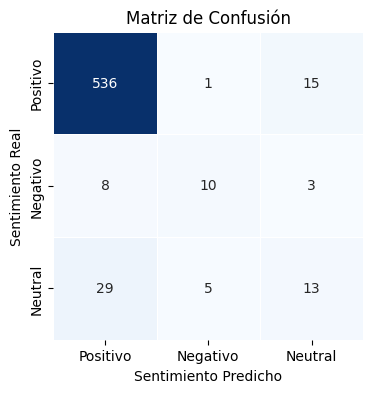

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=.5,
    cbar=False
)

plt.title('Matriz de Confusión')
plt.xlabel('Sentimiento Predicho')
plt.ylabel('Sentimiento Real')
plt.savefig("output/conf_matrix.png")
plt.show()

 # Conclusion

It can be seen that this model classifies positive feelings in a highly favorable way, given that it detects certain words within a dictionary that it considers positive. However, the error percentage is higher for negative and neutral comments, which is because in many comments there may be sarcasm or the use of apparently positive words in pejorative contexts. Additionally, some guests may leave reviews highlighting both positive and negative aspects they encountered during their stay.